In [1]:
import os
import shutil
from collections import defaultdict

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import matplotlib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from math import floor, ceil
matplotlib.rcParams['image.cmap'] = 'gray'

In [2]:
FILENAME = "data/exemple_corecte/image_1.jpg"
img = cv2.imread(FILENAME)

In [3]:
def img_to_bin(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img_bin) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    img_bin = 255 - img_bin
    
    return img_bin

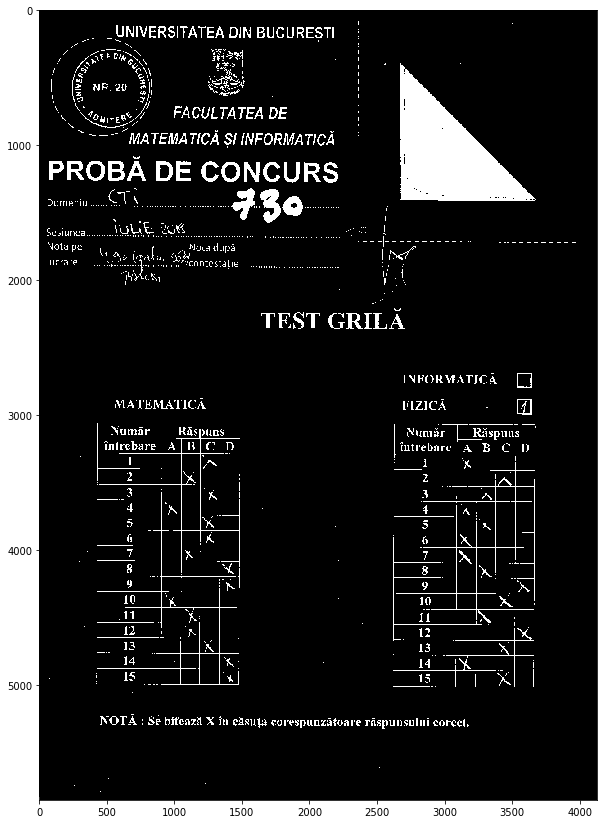

In [4]:
# Thresholding the image
img_bin = img_to_bin(img)
plt.figure(figsize=(10, 20))
plt.imshow(img_bin)

In [5]:
def test_kernel_length(img_bin, x, kernel_size=(3, 3)):
    # Defining a kernel length
    kernel_length = np.array(img_bin).shape[1]//x

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 20))
    ax1.imshow(verticle_lines_img)
    ax1.axis('off')

    ax2.imshow(horizontal_lines_img)
    ax2.axis('off')
    plt.show()
    
    return horizontal_lines_img, verticle_lines_img, kernel

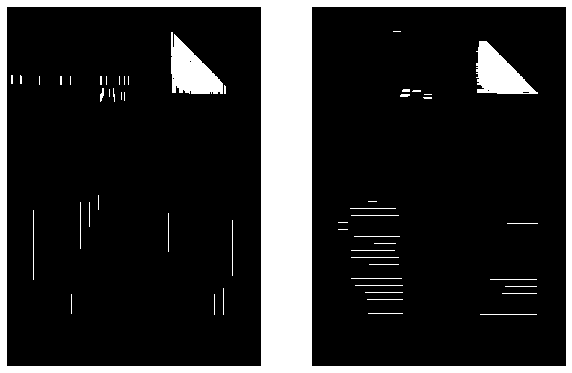

In [6]:
horizontal_lines_img, verticle_lines_img, kernel = test_kernel_length(img_bin, 100)

In [7]:
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
def combine_imgs(verticle_lines_img, horizontal_lines_img, alpha, beta):
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return img_final_bin

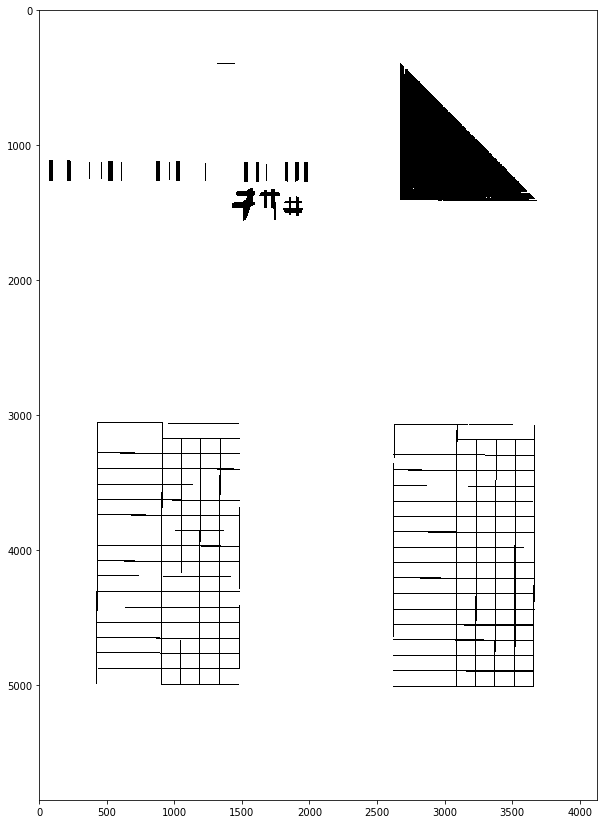

In [8]:
img_final_bin = combine_imgs(verticle_lines_img, horizontal_lines_img, alpha, beta)
plt.figure(figsize=(10,20))
plt.imshow(img_final_bin)

In [9]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [10]:
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="bottom-to-top")

In [11]:
question_boxes = []
for (x, y, w, h) in boundingBoxes:
    if w > 900 and h > 1500 and h < 3000:
        question_boxes.append((x, y, w, h))

2617 3061 1059 1952
424 3051 1069 1946


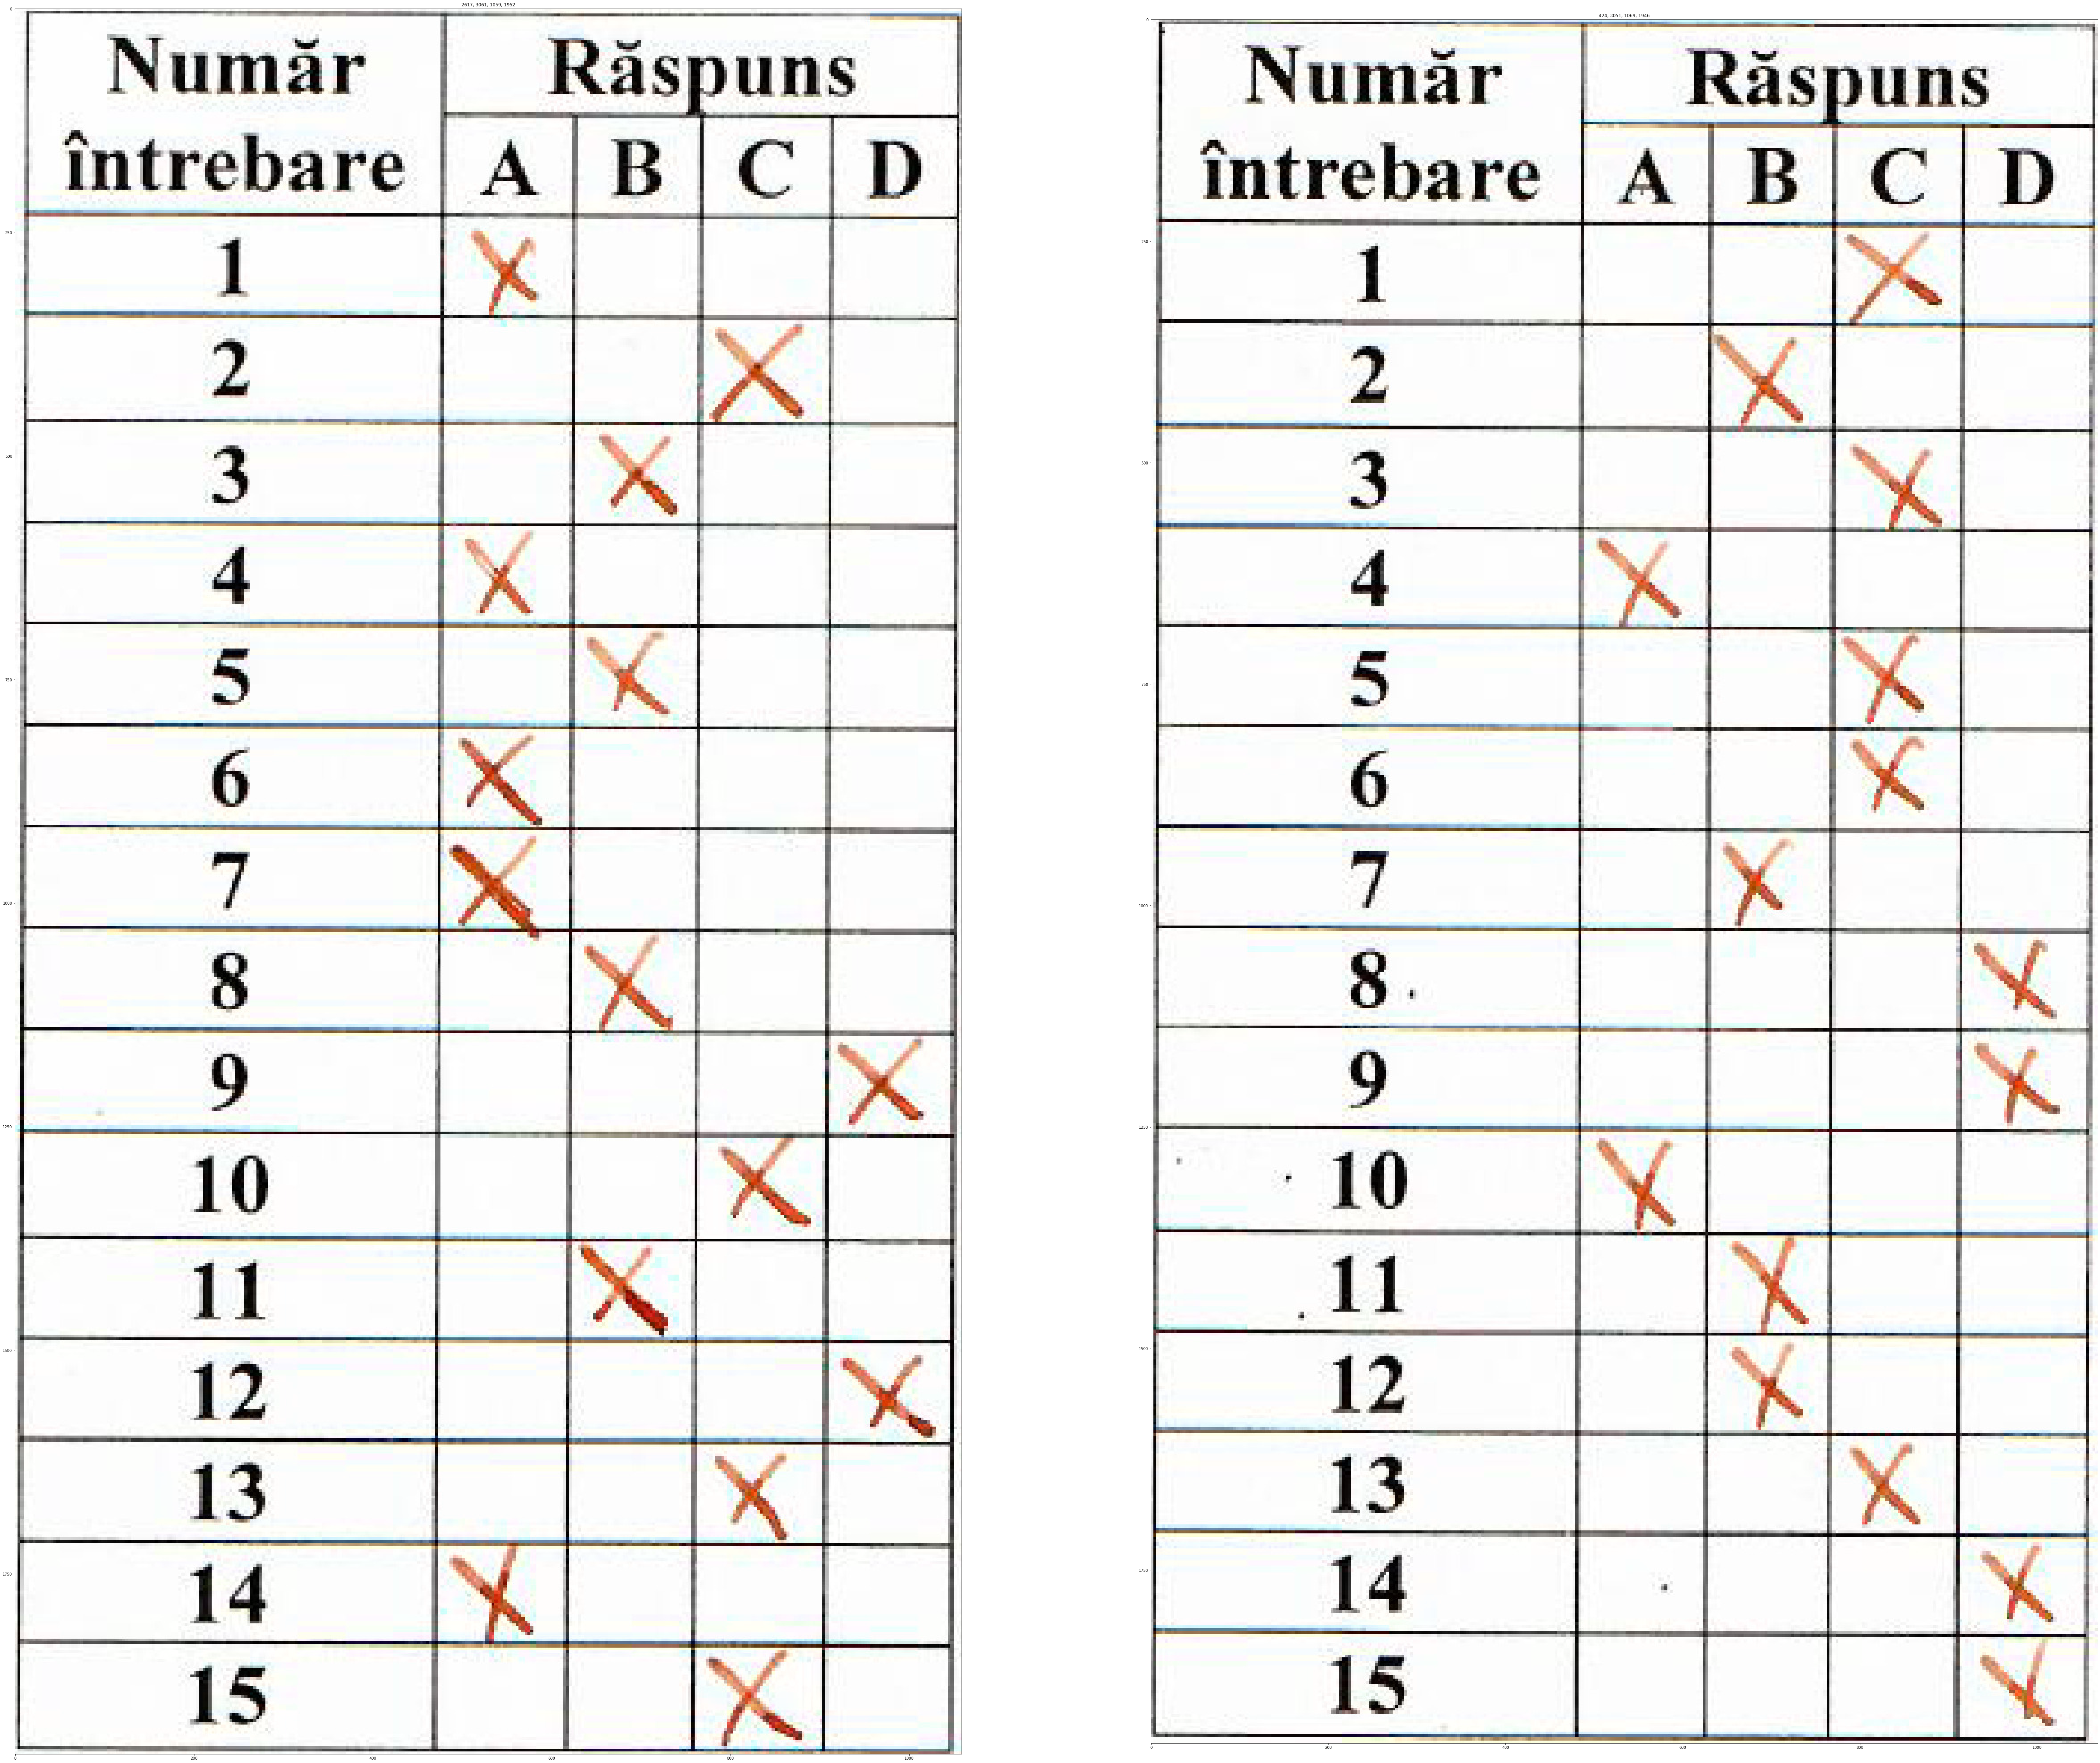

In [12]:
fig, ax = plt.subplots(1, len(question_boxes), figsize=(100, 100))

for i, (x, y, w, h) in enumerate(question_boxes):
    print(x, y, w, h)
    ax[i].set_title(f"{x}, {y}, {w}, {h}")
    ax[i].imshow(img[y:y+h, x:x+w])

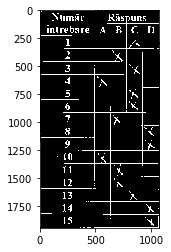

In [141]:
x, y, w, h = question_boxes[1]

box = img_bin[y:y+h, x:x+w]
plt.imshow(box)

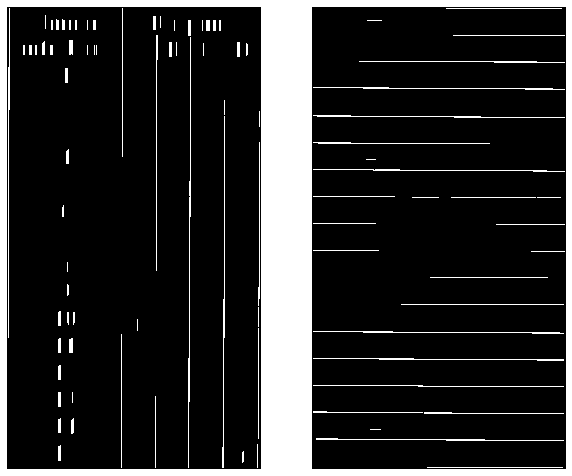

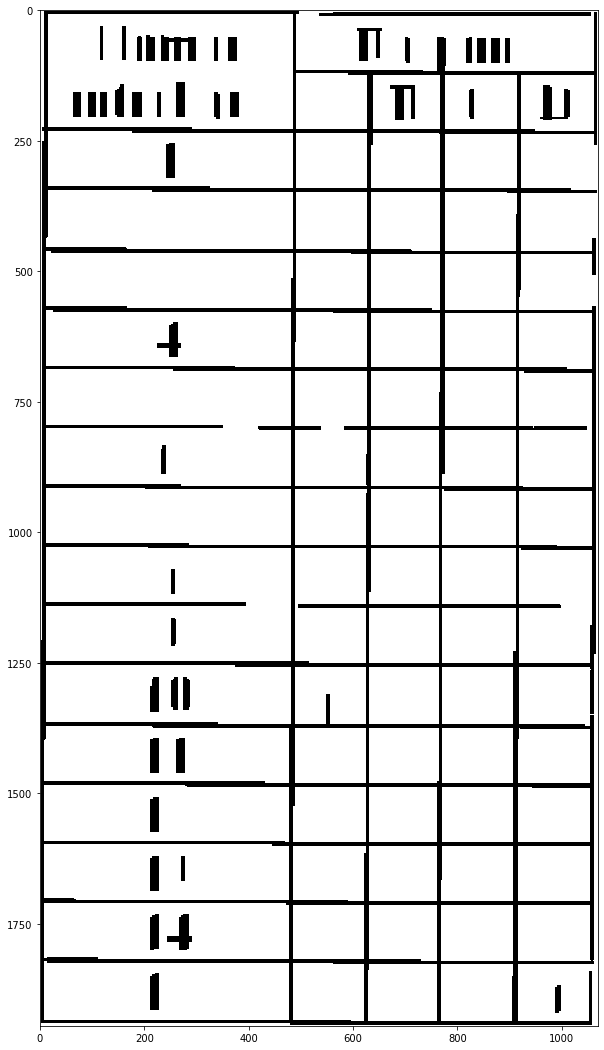

In [162]:
horizontal_lines_img, verticle_lines_img, kernel = test_kernel_length(box, 70)
final_box = combine_imgs(verticle_lines_img, horizontal_lines_img, alpha, beta)
plt.figure(figsize=(10, 20))
plt.imshow(final_box)

In [163]:
contours, hierarchy = cv2.findContours(final_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="left-to-right")
len(boundingBoxes)

115

In [164]:
good_imgs = []
rows = defaultdict(list)
for (x, y, w, h) in boundingBoxes:
    if w > 90 and h > 90 and h < 150 and w < 200:
        good_imgs.append(box[y:y+h, x:x+w])
        r = y - y%100
        rows[r].append([x, y, w, h])

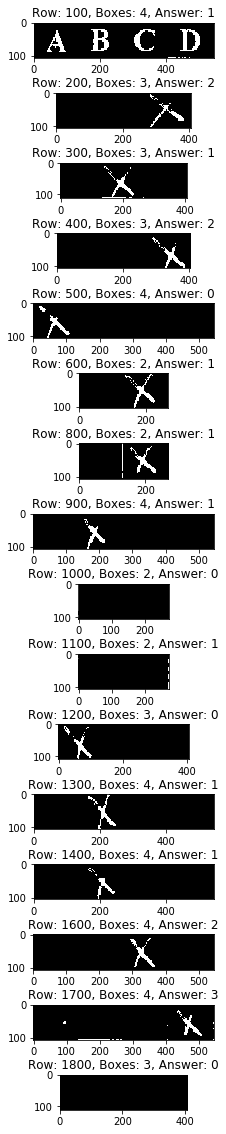

In [175]:
fig, ax = plt.subplots(len(rows), figsize=(20, 20))
plt.subplots_adjust(hspace=1)
index  = 0
for row, values in sorted(rows.items()):
#     print("row: ", row, "values: ", len(values), np.array(values))
    row_img = []
    # max_w = np.max(np.array(values)[:, 2])
    max_h = np.max(np.array(values)[:, 3])
#     print("max h", max_h)
    means = []
    for value in values:
        x, y, w, h = value
        empty_arr = np.full((max_h, w), 0)
        empty_arr[0:h, 0:w] = box[y:y + h, x:x + w]
        means.append(empty_arr.mean())
        row_img.append(empty_arr)
    row_img = np.concatenate(row_img, axis=1)
    ax[index].set_title(f"Row: {row}, Boxes: {len(values)}, Answer: {np.argmax(means)}")
    ax[index].imshow(row_img)
    index = index + 1
#     cv2.imwrite(cropped_dir_path + str(row) + ".png", row_img)

In [158]:
for row, values in sorted(rows.items()):
    print("row: ", row)
    i = np.argmax([box[y:y+h, x: x+w].mean() for (x, y, w, h) in values])
    

row:  0
row:  100
24.215801886792452
38.35271317829457
22.75179856115108
33.232479784366575
row:  200
0.0
0.7836620926243568
25.487532304253683
row:  300
0.0
29.284995977473855
1.6397147768510856
row:  400
0.7075471698113207
2.1869639794168094
26.816037735849058
row:  500
26.94685760825302
0.41262135922330095
0.0
1.9729876476177548
row:  600
1.6219982847341339
25.701650943396228
row:  800
0.0
27.819743935309972
row:  900
1.81722546491109
25.231461167178587
2.4915768194070083
1.2287905524636895
row:  1000
3.273868633848773
0.6701482479784366
row:  1100
0.3436657681940701
2.0619946091644206
row:  1200
26.404816513761467
0.0
0.0
row:  1300
0.0
29.42864236061853
1.2205188679245282
2.5960363784444143
row:  1400
1.246097461653319
19.43033381712627
0.12382075471698113
2.0768291027555312
row:  1600
3.8075200217184744
0.2220609579100145
27.500678702321164
0.03461381837925886
row:  1700
0.6985294117647058
4.163642960812772
0.121148364327406
21.599393530997304
row:  1800
2.8292410714285716
0.3693